### Seamless Bay Area Tweet Analysis: Part 4, Modeling
<br>
The goal of this project is to analyze the twitter account of the nonprofit group Seamless Bay Area and determine what makes up the most high-impact tweet as measured by engagements.
<br>
In part four we start doing modeling, either to see if there is a direct linear relationship between any tweet features and engagements or if any emergent categories of tweets are predictive.
<br>
<br>

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import statistics as stat
import re
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import random; random.seed(53)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('/Users/grahamsmith/Documents/SpringboardWork/Seamless_Twitter_Analysis/tweets with features.csv')

In [4]:
#Here is out data for reference
df.head() 

,Unnamed: 0.1,Unnamed: 0,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,...,url clicks,tweet words,links,replies_sentance,Negative words,Positive words,Sentiment Score,hour,minute,day
0,0,0,@MTCBATA is looking for a new Executive Direct...,2018-10-27 18:01:00,124.0,5.0,0.040323,0.0,[['@MTCBATA']],0.0,...,4.0,"['@mtcbata', 'is', 'looking', 'for', 'a', 'new...",https://t.co/Syf9exwPTd,"['@MTCBATA', 'is', 'looking', 'for', 'a', 'new...","['dire', 'in', 'ire', 'no', 'the']","['ace', 'add', 'as', 'big', 'can', 'candid', '...",0.086643,18,1,6
1,1,1,Ultimate seamlessness. https://t.co/CdCLrg2o6a,2018-10-26 14:24:00,345.0,10.0,0.028986,0.0,[],1.0,...,9.0,"['ultimate', 'seamlessness.', 'https://t.co/cd...",https://t.co/CdCLrg2o6a,"['Ultimate', 'seamlessness.', 'https://t.co/Cd...",[],"['mate', 'seamless', 'ultimate']",0.063830,14,24,5
2,2,2,Help Nix Prop 6! Save funding for more seamles...,2018-10-26 02:28:00,994.0,19.0,0.019115,4.0,[],5.0,...,5.0,"['help', 'nix', 'prop', 'save', 'funding', 'fo...","https://t.co/qM4M7tCFVO, https://t.co/2379qGdY2D","['Help', 'Nix', 'Prop', '6!', 'Save', 'funding...","['ding', 'in', 'lie']","['for', 'fun', 'help', 'hone', 'in', 'more', '...",0.044199,2,28,5
3,3,3,It doesn't have to be this way! Let's get to f...,2018-10-23 23:29:00,792.0,7.0,0.008838,2.0,[],4.0,...,0.0,"['it', ""doesn't"", 'have', 'to', 'be', 'this', ...",https://t.co/FczQtLbH5d,"['It', ""doesn't"", 'have', 'to', 'be', 'this', ...","['ill', 'in', 'the']","['box', 'da', 'fare', 'for', 'free', 'have', '...",0.055016,23,29,2
4,4,4,And then come say hi at next month’s @SPUR_Urb...,2018-10-23 23:09:00,532.0,3.0,0.005639,0.0,"[['@SPUR_Urbanist'], ['@icgee']]",1.0,...,0.0,"['and', 'then', 'come', 'say', 'hi', 'at', 'ne...",NaN,"['And', 'then', 'come', 'say', 'hi', 'at', 'ne...","['ill', 'in', 'itch', 'itching', 'the']","['as', 'for', 'great', 'idea', 'in', 'next', '...",0.034826,23,9,2


<br>
The first order of business is to build some models to predict engagement rate from tweet text. The question can be approached as a simple classification problem, where the label is “high engagement” (1) or “low engagement” (0).
<br>
<br>
In this case I'm defining "high engagement" as an engagement rate above the mean.
<br>
<br>
We’ll compare the results of using two models, each paired with the Multinomial Naive Bayes classifier.
<br>
<br>
The first model is Count vectorizer, which is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.
<br>
<br>
The second model is a slightly more complicated version called TFIDF, or the mouthful Term Frequency Inverse Document Frequency, which works by proportionally increasing the number of times a word appears in the document but is counterbalanced by the number of documents in which it is present. In other words, it finds words which are common in one class but not the other.
<br>
<br>

<br>
A few notes on the hyperparameters: min_df and max_df Ignore terms that have a document frequency higher than 90% (very frequent), and lower than the 5% (highly infrequent), this has a similar effect of the stopwords in that it pulls out useless words.
<br>
<br>
I attempted an ngram_range of (1,3) - meaning the vectorizers will incorporate bi- and tri-grams alongside single words, but it made almost literally no difference so I removed it. I felt unnessesary hyperparameters remove clarity without adding any additional information, although they do make your model feel cooler.
<br>
<br>

In [47]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,...,tweet words,links,replies_sentance,Negative words,Positive words,Sentiment Score,hour,minute,day,target
0,0,0,@MTCBATA is looking for a new Executive Direct...,2018-10-27 18:01:00,124.0,5.0,0.040323,0.0,[['@MTCBATA']],0.0,...,"['@mtcbata', 'is', 'looking', 'for', 'a', 'new...",https://t.co/Syf9exwPTd,"['@MTCBATA', 'is', 'looking', 'for', 'a', 'new...","['dire', 'in', 'ire', 'no', 'the']","['ace', 'add', 'as', 'big', 'can', 'candid', '...",0.086643,18,1,6,1
1,1,1,Ultimate seamlessness. https://t.co/CdCLrg2o6a,2018-10-26 14:24:00,345.0,10.0,0.028986,0.0,[],1.0,...,"['ultimate', 'seamlessness.', 'https://t.co/cd...",https://t.co/CdCLrg2o6a,"['Ultimate', 'seamlessness.', 'https://t.co/Cd...",[],"['mate', 'seamless', 'ultimate']",0.063830,14,24,5,1
2,2,2,Help Nix Prop 6! Save funding for more seamles...,2018-10-26 02:28:00,994.0,19.0,0.019115,4.0,[],5.0,...,"['help', 'nix', 'prop', 'save', 'funding', 'fo...","https://t.co/qM4M7tCFVO, https://t.co/2379qGdY2D","['Help', 'Nix', 'Prop', '6!', 'Save', 'funding...","['ding', 'in', 'lie']","['for', 'fun', 'help', 'hone', 'in', 'more', '...",0.044199,2,28,5,0
3,3,3,It doesn't have to be this way! Let's get to f...,2018-10-23 23:29:00,792.0,7.0,0.008838,2.0,[],4.0,...,"['it', ""doesn't"", 'have', 'to', 'be', 'this', ...",https://t.co/FczQtLbH5d,"['It', ""doesn't"", 'have', 'to', 'be', 'this', ...","['ill', 'in', 'the']","['box', 'da', 'fare', 'for', 'free', 'have', '...",0.055016,23,29,2,0
4,4,4,And then come say hi at next month’s @SPUR_Urb...,2018-10-23 23:09:00,532.0,3.0,0.005639,0.0,"[['@SPUR_Urbanist'], ['@icgee']]",1.0,...,"['and', 'then', 'come', 'say', 'hi', 'at', 'ne...",NaN,"['And', 'then', 'come', 'say', 'hi', 'at', 'ne...","['ill', 'in', 'itch', 'itching', 'the']","['as', 'for', 'great', 'idea', 'in', 'next', '...",0.034826,23,9,2,0


In [18]:
#create our classes
mean = df['engagement rate'].mean()
df['target'] = np.where((df['engagement rate'] > mean), 1, 0)

In [19]:
#this is the proportion of our classes
print('the proportion of our classes is: ' + str(len( df[df['engagement rate'] > mean] )/ len(df)))

the proportion of our classes is: 0.34593152512227654


In [20]:
#create target 
y = df['target']

#create train and test set
X_train, X_test, y_train, y_test = train_test_split(df['Tweet text'], y, random_state=53, test_size=.25, stratify=y)

#define stopwords
stopwords = ['mon','articl','amp',"https","0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]

# initialize count vectorizer with english stopwords eliminating the least and most frequent words
count_vectorizer = CountVectorizer(stop_words=stopwords, min_df=.05, max_df=.9)

# create count train and test variables
count_train = count_vectorizer.fit_transform(X_train, y_train)
count_test = count_vectorizer.transform(X_test)

# initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=.05, max_df=0.9)

# create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train, y_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [21]:
# create a MulitnomialNB model
tfidf_nb = MultinomialNB()
tfidf_nb.fit(tfidf_train, y_train)

# get predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# calculate accuracy
tfidf_nb_score = accuracy_score(y_test, tfidf_nb_pred)

# create a MulitnomialNB model
count_nb = MultinomialNB()
count_nb.fit(count_train, y_train)

# get predictions
count_nb_pred = count_nb.predict(count_test)

# calculate accuracy
count_nb_score = accuracy_score(y_test, count_nb_pred)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.6536412078152753
NaiveBayes Count Score:  0.650088809946714


<br>
Tfidf is the winner with 0.66% accuracy, although Count was very close. However this isn't super useful to us on its own, let's see what words are especially predictive.
<br>
<br>
Also a pure accuracy score isn't super useful all on its own, so lets get some more details.
<br>
<br>

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, count_nb_pred))

              precision    recall  f1-score   support

           0       0.66      0.97      0.78       368
           1       0.45      0.05      0.08       195

    accuracy                           0.65       563
   macro avg       0.55      0.51      0.43       563
weighted avg       0.59      0.65      0.54       563



<br>
This tells us that the model was about 33% more precise (the % of predictions that were accurate) with low engagement tweets than with high engagement ones. 
<br>
<br>
The model's recall (the % of all correct answers that were accurately found) was also better for low engagement tweets, but by a considerably higher margin - nearly two orders of magnitude. 
<br>
<br>
This means that while the model was decent at guessing whether or not a tweet would be low engagement, it's actually much worse at catching high engagement ones than the overall weighted average would imply. It misclassified 92% of high engagement tweets.
<br>
<br>

In [23]:
print(classification_report(y_test, tfidf_nb_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       368
           1       0.00      0.00      0.00       195

    accuracy                           0.65       563
   macro avg       0.33      0.50      0.40       563
weighted avg       0.43      0.65      0.52       563



<br>
Strangely enough, TFIDF is actually completely missing all the high engagement tweets so its accuracy is actually very deceptive. This indicates we should be just using regular counts instead.
<br>
<br>
That direction doesn't seem especially useful, so why don't we try just looking at which words occured most frequently with one class over the other.
<br>
<br>

In [24]:
#get top 10 keywords
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
tfidf_sorting = np.argsort(feature_names.flatten())[::-1]

top_10 = feature_names[tfidf_sorting][:10]
bottom_10 = feature_names[tfidf_sorting][-10:]

print(f'''Top 10 keywords most likely to elicit a higher engagement rate are: 
{top_10}, and the top 10 keywords most likely to elicit a lower engagement were: {bottom_10}''')

Top 10 keywords most likely to elicit a higher engagement rate are: 
['work' 'transportation' 'transit' 'today' 'support' 'spur_urbanist'
 'service' 'seamless' 'riders' 'regional'], and the top 10 keywords most likely to elicit a lower engagement were: ['integration' 'integrated' 'funding' 'fares' 'fare' 'caltrain' 'board'
 'bay' 'area' 'agencies']


<br>
This is probably easier to see as a wordcloud.
<br>
<br>

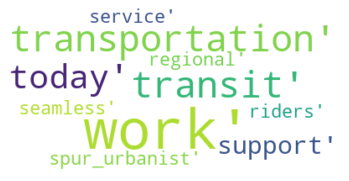

In [79]:
#Top 10 keywords most likely to elicit a higher engagement rate are
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(feature_names[tfidf_sorting][:10]))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

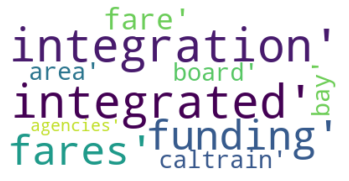

In [80]:
#Top 10 keywords most likely to elicit a lower engagement rate are
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(feature_names[tfidf_sorting][-10:]))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<br>
This is a little hard to interpret, but it seems like tweets that indicate an immediate call to action ('today', 'support') do well, and people apparently don't like to hear about caltrain! I'm not sure what to take away from the fact that so many phrases related to the bay area do poorly.
<br>
<br>

In [76]:
str(feature_names[tfidf_sorting][:10])

"['work' 'transportation' 'transit' 'today' 'support' 'spur_urbanist'\n 'service' 'seamless' 'riders' 'regional']"

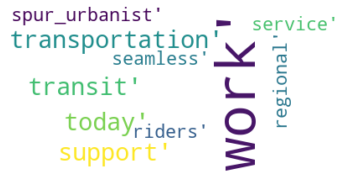

<br>
Words alone might make a tweet, but they are just one thing that impacts audience’s engagement with it.
<br>
<br>
We can try to predict engagement rate using a set of other tweets’ features. Specifically: day of the week, hour of the day, minute, number of mentions the tweet includes, and sentiment score,
<br>
<br>
Let's make these features and plug them into a linear regression.
<br>
<br>

In [25]:
import emoji

#function to check if sth is an emoji
def char_is_emoji(character):
    return emoji.distinct_emoji_list(character)

#function to count emoji
def emoji_counter(text_string):
    count = 0
    for x in text_string:
        a = char_is_emoji(x)
        if len(a) > 0:
            count += 1
    return count
  
df['emoji_count'] = df['Tweet text'].apply(emoji_counter)

In [26]:
temp = []
for x in df['replies']:
    if len(x) > 0:
        a = re.sub('\[', '', str(x))
        b = re.sub('\]', '', a)
        c = re.sub('\'', '', b)
        d = re.sub('\,', '', c)
        temp.append(re.split(' ', d))
    else:
        temp.append('')
temp2 = []
for x in temp:
    temp2.append(len(x))
df['sum_mentions'] = temp2

In [27]:
#Let's check tweets with links and find it's correlation with engagements
has_links = []
for x in df['links']:
    if type(x) == str:
        has_links.append(1)
    else:
        has_links.append(0)

In [28]:
temp = []
for x in df['links']:
    temp.append(re.split(' ', str(x)))
temp2 = []
for x in temp:
    temp2.append(len(x))
df['link_count'] = temp2

In [29]:
df['word_count'] = [len(re.split(' ', x)) for x in df['Tweet text']]

In [30]:
#create a df for linear regression, 
df_pred_lr = df[['engagement rate','day','hour', 'minute', 'sum_mentions',
                  'emoji_count', 'word_count','link_count', 'Sentiment Score']]
#create features
x_lr = df_pred_lr.iloc[:,1:]

#create target
y_lr = df_pred_lr['engagement rate']

x_lr.head()

,day,hour,minute,sum_mentions,emoji_count,word_count,link_count,Sentiment Score
0,6,18,1,1,0,50,1,0.086643
1,5,14,24,1,0,4,1,0.063830
2,5,2,28,1,0,27,2,0.044199
3,2,23,29,1,0,46,1,0.055016
4,2,23,9,2,0,35,1,0.034826


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#create new train & test set
X_train, X_test, y_train, y_test = train_test_split(x_lr, y_lr, random_state=53, test_size=.33)

#initialise model
lr = LinearRegression()

#fit & predict
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

#evaluate
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, lr_pred))
print('Root Mean Standard Deviation (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, lr_pred)))
print('Observation Standard Deviation:', np.std(df['engagement rate']))

Mean Squared Error (MSE): 0.0007673429816235223
Root Mean Standard Deviation (RMSE): 0.02770095633048654
Observation Standard Deviation: 0.026600178403302095


<br>
A RMSE that's greater than half the standard deviation of the observed data is considered high, so this is a very good score (almost suspiciously so, it makes me think I might have messed something up)
<br>
<br>
source: https://elibrary.asabe.org/abstract.asp?aid=23153
<br>
<br>

<br>
However RMSE is a bit hard to interpret because you need to keep in mind the size of the units to interpret this. We can use Mean Absolute Percentage Error (MAPE) instead, which is the average of the absolute value of the predicted values subtracted by the real values.
<br>
<br>

In [32]:
#calculate the MAPE
MAPE = []
for x in y_test:
    for y in lr_pred:
        MAPE.append(x - y)
print('Mean Absolute Percentage Error is: ' + (str(np.round(np.mean(np.abs(MAPE)), decimals=3))))

Mean Absolute Percentage Error is: 0.018


<br>
Still pretty good! this means that on average, prediction are 18% off, which is not bad at all.
<br>
<br>
We can double check this by building a histogram of the residuals:
<br>
<br>

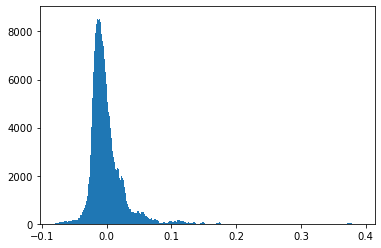

In [33]:
#calculate residuals and build a histogram
resids = []
for x in y_test:
    for y in lr_pred:
        resids.append(x - y)
resids = np.array(resids)
plt.hist(resids, bins='auto')
plt.show()

<br>
This is still not very helpful from a business standpoint. If we want to make actual recommendtion to our stakeholders we need to get the coefficients and see how significant they are.
<br>
<br>

,day,hour,minute,sum_mentions,emoji_count,word_count,link_count,sentiment_score,y
0,6,18,1,1,0,50,1,0.086643,0.040323
1,5,14,24,1,0,4,1,0.063830,0.028986
2,5,2,28,1,0,27,2,0.044199,0.019115
3,2,23,29,1,0,46,1,0.055016,0.008838
4,2,23,9,2,0,35,1,0.034826,0.005639
...,...,...,...,...,...,...,...,...,...
2244,1,18,57,1,0,42,1,0.052083,0.010833
2245,6,23,31,5,0,7,1,0.000000,0.024490
2246,6,1,11,1,2,7,1,0.061224,0.003135
2247,5,0,52,1,1,44,1,0.057762,0.013072


In [42]:
#make the regression and get a summary
import statsmodels.formula.api as smf
regdf = x_lr
regdf = regdf.rename(columns={'Sentiment Score': 'sentiment_score'})
regdf['y'] = y_lr
results = smf.ols('y ~ day + hour + minute + sum_mentions + emoji_count + word_count + link_count + sentiment_score', data=regdf).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     20.84
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           9.92e-31
Time:                        17:36:13   Log-Likelihood:                 5046.3
No. Observations:                2249   AIC:                        -1.007e+04
Df Residuals:                    2240   BIC:                        -1.002e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0202      0.003     

<br>
Despite the tight residuals and great MAPE score, only a few of the parameters were statistically significant. The impact of the coefficients also appears to be fairly small. Are they still important? Well, that's going to depend on the distribution of our target variable. Let's look at that.
<br>
<br>

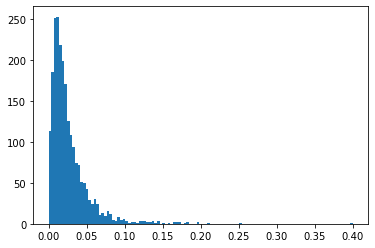

In [46]:
plt.hist(regdf['y'], bins='auto')
plt.show()

<br>
Now let's look at the absolute values of the statistically significant parameters in the model.
<br>
<br>

In [54]:
data = [['day',  0.0006], ['sum_mentions', 0.0041], ['sentiment_score', -0.0435]]
para = pd.DataFrame(data, columns=['Parameter', 'Coefficient'])
para

,Parameter,Coefficient
0,day,0.0006
1,sum_mentions,0.0041
2,sentiment_score,-0.0435


In [63]:
print(f'The average engagement score is: ' + str(round(np.mean(regdf['y']), 5)))

The average engagement score is: 0.0265


<br>
Given that mean engagement rate is only 2.6%, the small coefficients are more impactful than they appear. Tweeting later in the day has a slight effect on engagement rate, increasing it by 0.06%. Total number of mentions is a bit better, increasing engagemnet by 0.41%. Sentiment has the largest impact at 4.3%, although interestingly it's a negative impact meaning that having more negative words (or fewer positive ones) actually increases engagement rate.

<br>
As an example let's see what the best day to tweet is, holding all other variabeles at their mean values.
<br>
<br>

In [69]:
#%%capture [--no-stderr]
#check same values but diff day of the week
l = {}
for item in range(0,7):
    prediction = lr.predict([[item,np.mean(x_lr['hour']),np.mean(x_lr['minute']),np.mean(x_lr['sum_mentions']),np.mean(x_lr['emoji_count']),np.mean(x_lr['word_count']),np.mean(x_lr['link_count']),np.mean(x_lr['Sentiment Score'])]])
    l[item] = prediction
    print(f'day ' + str(item + 1) + ' has a predicted engagement rate of ' + str(prediction))

day 1 has a predicted engagement rate of [0.02350074]
day 2 has a predicted engagement rate of [0.0243688]
day 3 has a predicted engagement rate of [0.02523687]
day 4 has a predicted engagement rate of [0.02610494]
day 5 has a predicted engagement rate of [0.02697301]
day 6 has a predicted engagement rate of [0.02784107]
day 7 has a predicted engagement rate of [0.02870914]


<br>
It looks like tweeting on a Sunday (day 7) has the highest engagement rate.
<br>
<br>
We can also visualize the pairwise correlations of the variables:
<br>
<br>

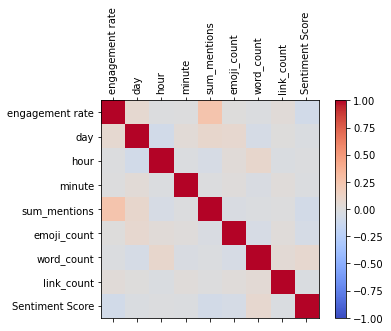

In [83]:
data = df[['engagement rate','day','hour', 'minute', 'sum_mentions',
                  'emoji_count', 'word_count','link_count', 'Sentiment Score']]
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

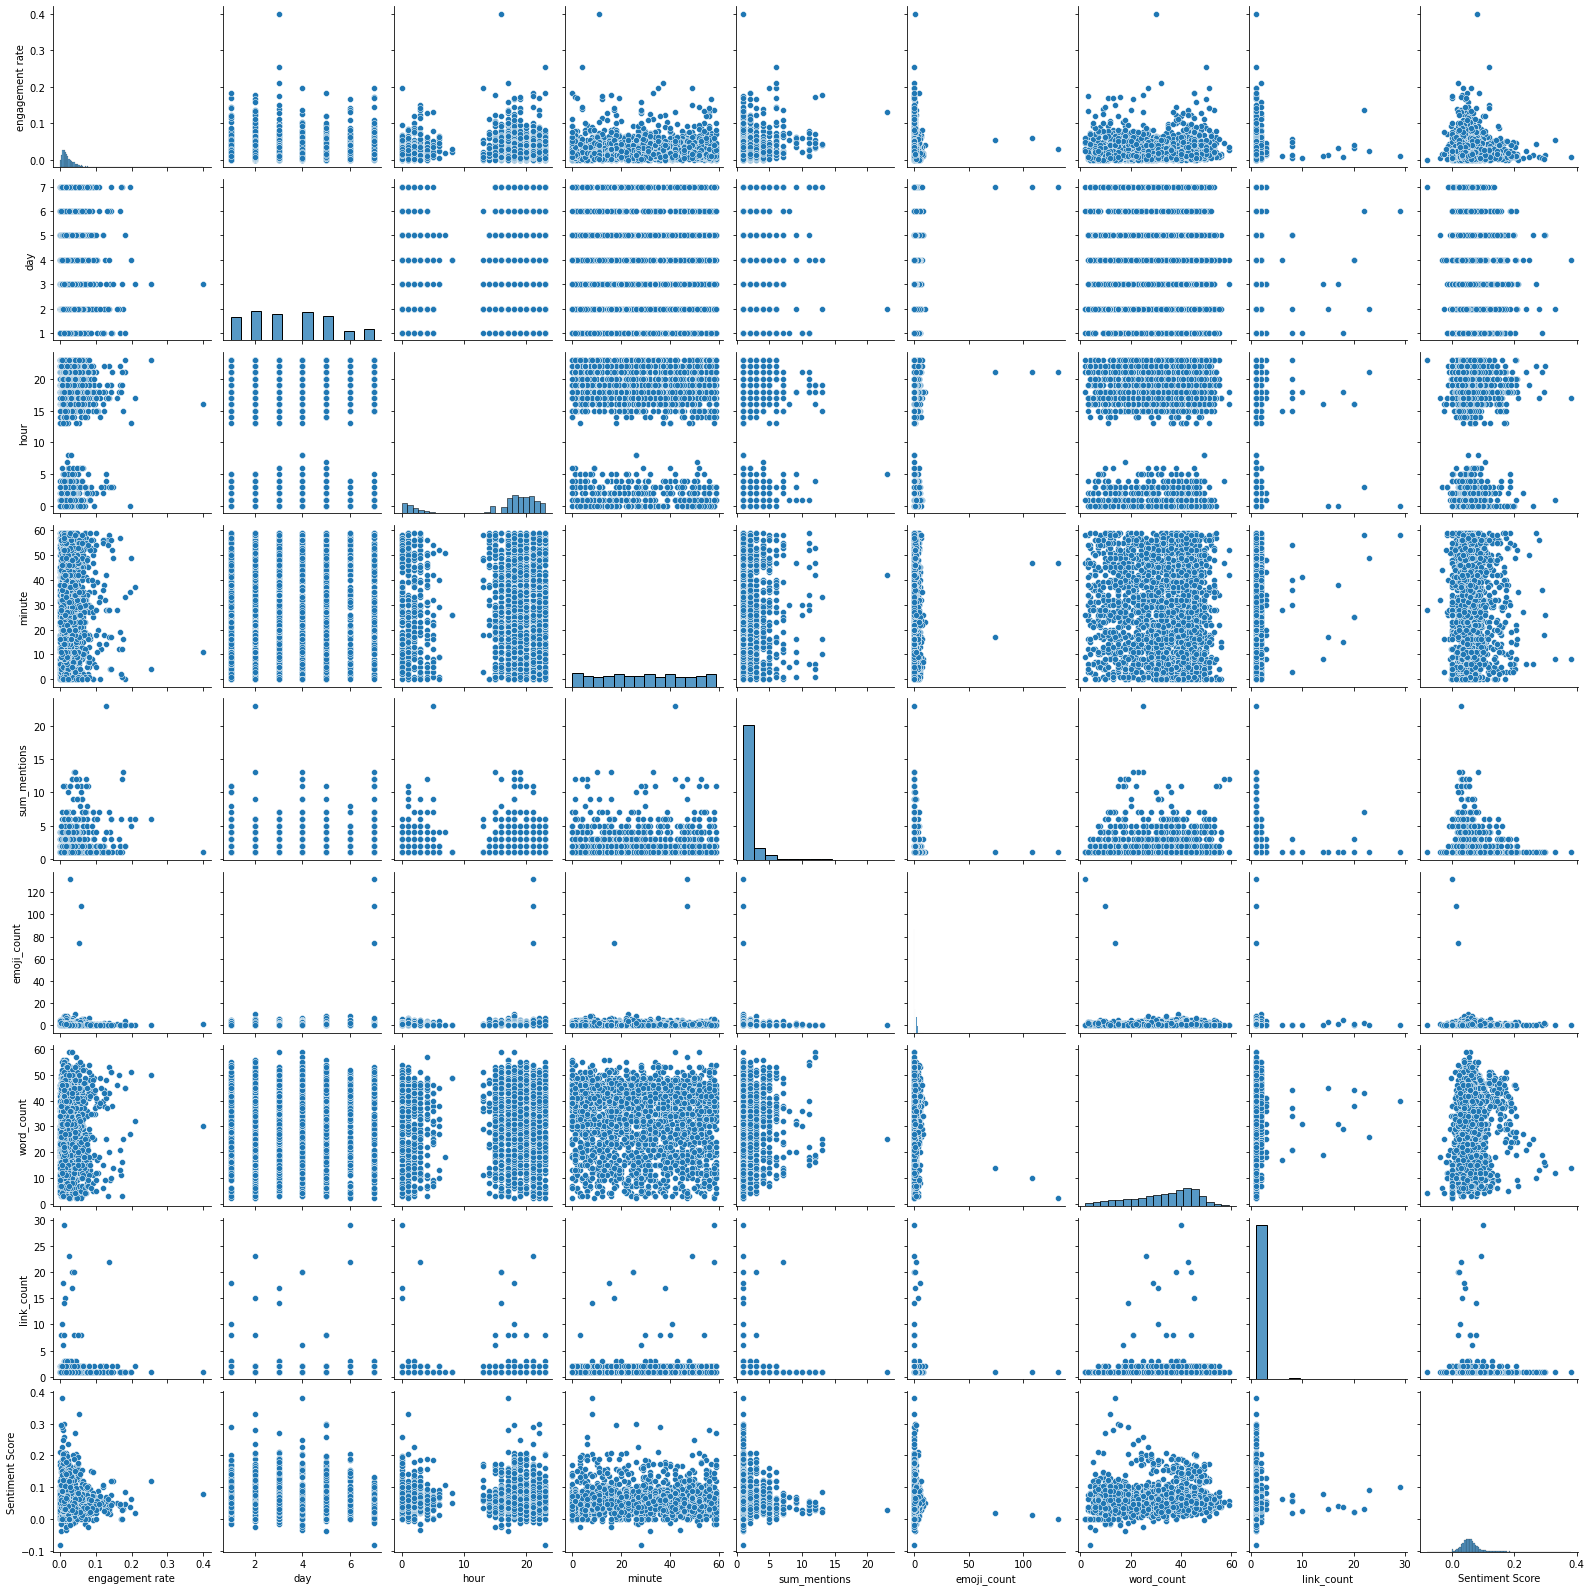

In [84]:
#or alternatively, we can see it as a pairplot as well
from seaborn import pairplot
pairplot(data)

#### Summary
<br>
Unfortunately, there isn't nearly as much to say as I would like. The top words associated with good/bad tweets seems like the only
<br>
For further work It would be great to combine the results from the Naive Bayes model applied to words and the linear regression applied to other variables.
<br>
<br>
I’d also like to know how to calculate the values of the variables that maximise the engagement rate.
<br>
<br>